In [268]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

import tensorflow as tf

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score,
    confusion_matrix,ConfusionMatrixDisplay
)

In [269]:
# Searching for a palette for figures
fig = px.colors.qualitative.swatches()
fig.show()

In [270]:
print(px.colors.qualitative.Vivid)

['rgb(229, 134, 6)', 'rgb(93, 105, 177)', 'rgb(82, 188, 163)', 'rgb(153, 201, 69)', 'rgb(204, 97, 176)', 'rgb(36, 121, 108)', 'rgb(218, 165, 27)', 'rgb(47, 138, 196)', 'rgb(118, 78, 159)', 'rgb(237, 100, 90)', 'rgb(165, 170, 153)']


In [271]:
# Settung palette colours
blue = px.colors.qualitative.Vivid[7]
pink = px.colors.qualitative.Vivid[4]
yellow = px.colors.qualitative.Vivid[6]
grey = px.colors.qualitative.Vivid[10]
black = "#202022"
bgcolor = "#f4f0ea"
green = px.colors.qualitative.Vivid[3]

## **Part 1. Loading the data**

In [272]:
df = pd.read_csv("spam.csv", encoding="latin-1")

#Remove missing values
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [273]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [274]:
max(df['message_len'])

171

## **Part 2. ETA**

In [275]:
# Identify if the data set is balanced or no
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [276]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=yellow
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:sans-serif">Dataset Distribution By Target</span>'
)
fig.show()


In [277]:
#According to the result we get bellow, we can consider using resampling.

ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color=blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=yellow,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:sans-serif">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

## **Part 3. Data Pre-Processing**

In [278]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

    #Firstly, we need to clean text from a brackets, links,punctuation and containing numbers. In additional,
    #we change all words to lowercase. Using replace func.

In [279]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


In [280]:
# Continuing the clening part, I will work with the stop words (they doesn't have contextual meaning in a sentence).
# Seems to tokenezation part
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


In [281]:
#Stemming&Lemmitization
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


In [282]:
#Final part of cleaning
def preprocess_data(text):
    # Clean puntuation, urls, etc
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text


df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


In [283]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


## **Part 4. Tokens Visualization**

In [284]:
#To prepare more customized and topic-related result of analysis, make sense to crete custom visual elements

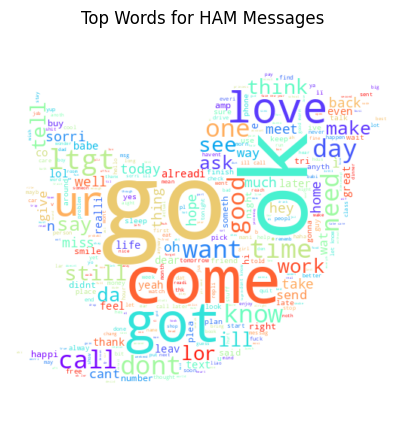

In [285]:
twitter_mask = np.array(Image.open('masks/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=500, 
    mask=twitter_mask,
    colormap='rainbow',
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))
plt.figure(figsize=(10,5))
plt.title('Top Words for HAM Messages', fontdict={'size': 12,  'verticalalignment': 'bottom'})
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

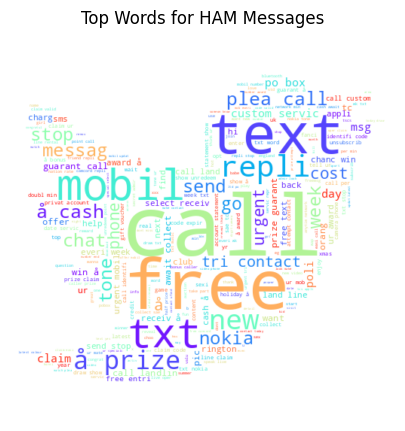

In [286]:
twitter_mask = np.array(Image.open('masks/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=500, 
    mask=twitter_mask,
    colormap='rainbow',
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))
plt.figure(figsize=(10,5))
plt.title('Top Words for HAM Messages', fontdict={'size': 12,  'verticalalignment': 'bottom'})
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

## **Part 5. Vectorization.**

In [287]:
# The messages is the list of tokens (lemmas) which we works with. They should be transform to the vectors.
# It will be done using the SciKit Learn's algorithm models.

x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [288]:
# Split into train and test sets. Using 'train_test_split' I splited arrays or matrices into random train and test subsets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [289]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)


CountVectorizer()

In [290]:
vect.fit(x_test)

CountVectorizer()

In [291]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [292]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [293]:
# tf–idf is one of the most popular term-weighting schemes today. It helps identify the short for term frequency–inverse document frequency.

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x3149 sparse matrix of type '<class 'numpy.float64'>'
	with 26950 stored elements in Compressed Sparse Row format>

In [294]:
texts = df['message_clean']
target = df['target_encoded']

In [295]:
# Is the time for perform tokenization (segmenting text into sentences of words).

# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6726

In [296]:
sequences = [[1], [2, 3], [4, 5, 6]]
tf.keras.utils.pad_sequences(sequences, padding='post')

array([[1, 0, 0],
       [2, 3, 0],
       [4, 5, 6]], dtype=int32)

In [297]:
nltk.download('punkt')

def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

In [298]:
# With the help of GloVe, we may find semantic relationships between words from the co-occurrence matrix.
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings, embeddings_dictionary
with open('glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions


In [299]:
# Load embedding vectors of those words that appear in the Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## **Part 6. Modeling**

In [300]:
# Create a Multinomial Naive Bayes model to build simple classification
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [301]:
# Make the class and probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

0.9569274946159368


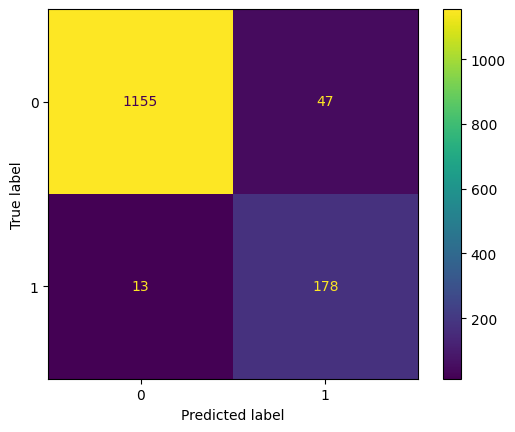

In [302]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

cx=metrics.confusion_matrix(y_test, y_pred_class)
cx_display = ConfusionMatrixDisplay(cx).plot()

In [303]:
# Calculate another common metric
metrics.roc_auc_score(y_test, y_pred_prob)

0.9802771994320112

In [304]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

0.9597989949748744


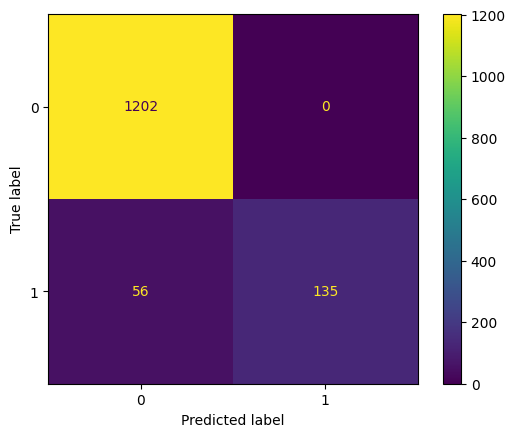

In [305]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

cm=metrics.confusion_matrix(y_test, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [306]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Train: 0.9834888729361091
Test: 0.9662598707824839


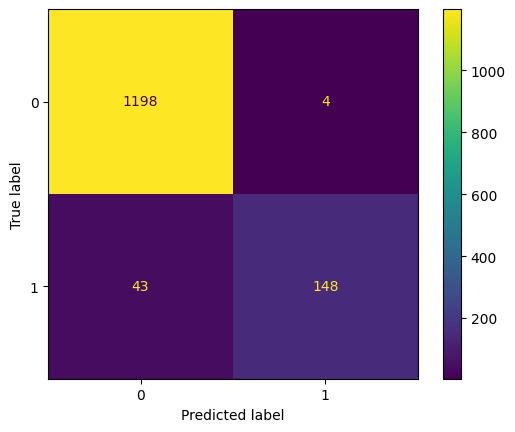

In [307]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

cm1=metrics.confusion_matrix(y_test, y_pred_class)
cm1_display = ConfusionMatrixDisplay(cm1).plot()

## **Part 7. LSTM (long-short time memory networks)**

In [308]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

In [309]:
# The model was taken from OPEN SOURCE https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 80, 100)           672600    
                                                                 
 bidirectional_6 (Bidirectio  (None, 80, 160)          115840    
 nal)                                                            
                                                                 
 global_max_pooling1d_6 (Glo  (None, 160)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_6 (Batc  (None, 160)              640       
 hNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 160)               0         
                                                      

In [310]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8897
Epoch 1: val_loss improved from inf to 0.37477, saving model to model.h5
131/131 [==============================] - 32s 208ms/step - loss: 0.3209 - accuracy: 0.8897 - val_loss: 0.3748 - val_accuracy: 0.9512 - lr: 0.0010
Epoch 2/7
131/131 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9380
Epoch 2: val_loss did not improve from 0.37477
131/131 [==============================] - 30s 226ms/step - loss: 0.1819 - accuracy: 0.9380 - val_loss: 0.3840 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 3/7
131/131 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9576
Epoch 3: val_loss improved from 0.37477 to 0.10252, saving model to model.h5
131/131 [==============================] - 27s 203ms/step - loss: 0.1387 - accuracy: 0.9576 - val_loss: 0.1025 - val_accuracy: 0.9627 - lr: 0.0010
Epoch 4/7
131/131 [==============================] - ETA: 0s - loss: 0.1009 -

In [311]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

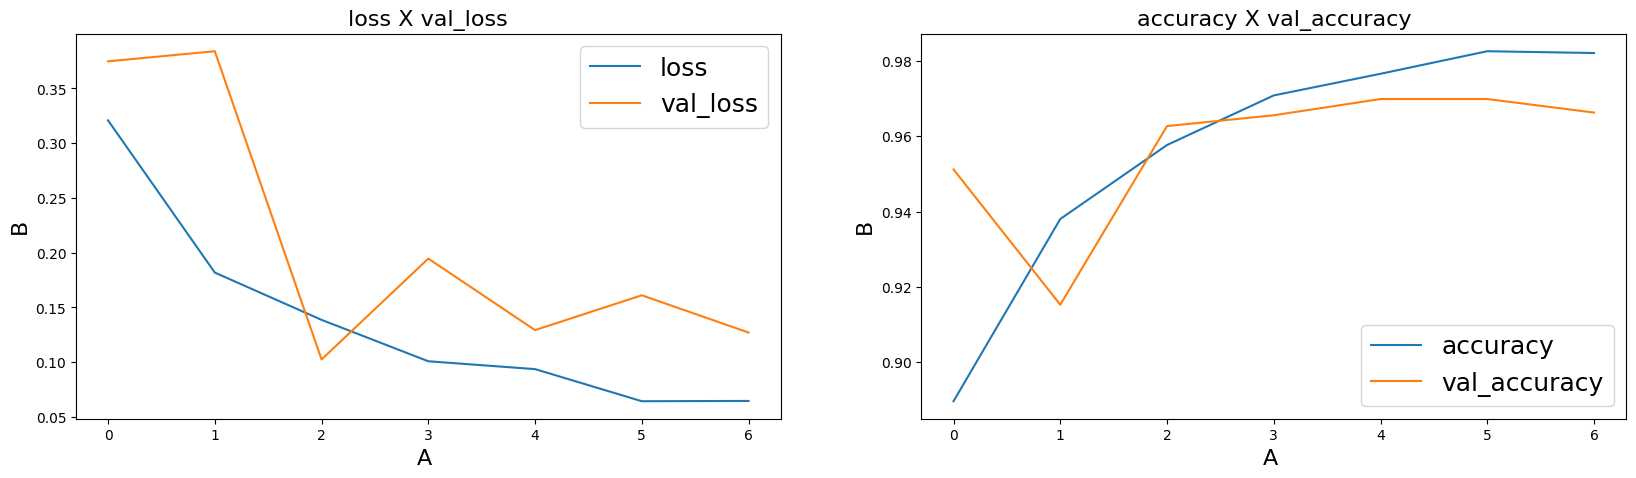

In [312]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

44/44 [==============================] - 2s 35ms/step


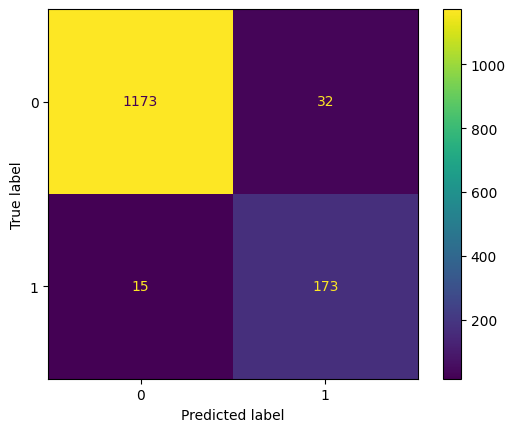

In [313]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
cm2=metrics.confusion_matrix(y_test, y_preds)
cm2_display = ConfusionMatrixDisplay(cm2).plot()

## **PRACTICE. NLP a dissaster Tweets**

In [314]:
df = pd.read_csv("train.csv", encoding="latin-1")
test_df = pd.read_csv("test.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))

df.head()

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


In [315]:
# EDA
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271])

In [316]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=green
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=pink
))
fig.update_layout(
    title='<span style="font-size:24px; font-family:sans-serif">Dataset distribution by target</span>'
)
fig.show()

In [317]:
disaster_df = df[df['target'] == 1]['text_len'].value_counts().sort_index()
fake_df = df[df['target'] == 0]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=disaster_df.index,
    y=disaster_df.values,
    name='Real disaster',
    fill='tozeroy',
    marker_color=green,
))
fig.add_trace(go.Scatter(
    x=fake_df.index,
    y=fake_df.values,
    name='Fake',
    fill='tozeroy',
    marker_color=pink,
))
fig.update_layout(
    title='<span style="font-size:24px; font-family:sans-serif">Data Roles in Different Fields</span>'
)
fig.show()

In [318]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [319]:
test_df['text_clean'] = test_df['text'].apply(preprocess_data)

df['text_clean'] = df['text'].apply(preprocess_data)
df.head()

,id,text,target,text_len,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


In [320]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [321]:
corpus_disaster_tweets = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('fire', 266),
 ('bomb', 179),
 ('kill', 158),
 ('news', 132),
 ('via', 121),
 ('flood', 120),
 ('disast', 116),
 ('california', 115),
 ('crash', 110),
 ('suicid', 110)]

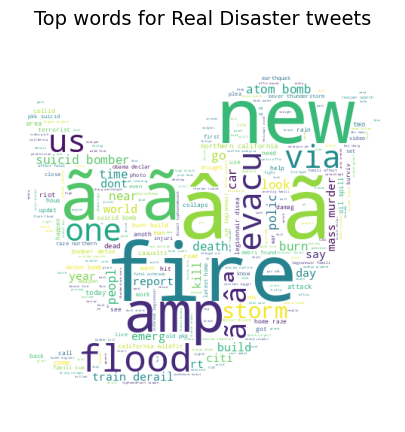

In [322]:
twitter_mask = np.array(Image.open('masks/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=500, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'text_clean']))
plt.figure(figsize=(10,5))
plt.title('Top words for Real Disaster tweets', 
          fontdict={'size': 14,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [323]:
corpus_disaster_tweets = create_corpus_df(df, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 306),
 ('get', 222),
 ('amp', 192),
 ('new', 168),
 ('go', 142),
 ('dont', 139),
 ('one', 134),
 ('bodi', 116),
 ('love', 115),
 ('bag', 108)]

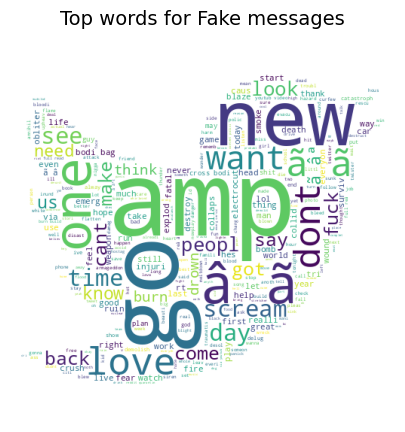

In [324]:
wc = WordCloud(
    background_color='white', 
    max_words=500, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'text_clean']))
plt.figure(figsize=(10,5))
plt.title('Top words for Fake messages', 
          fontdict={'size': 14,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [325]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['text_clean']
y = df['target']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Train: 0.861271676300578
Test: 0.7736344537815126


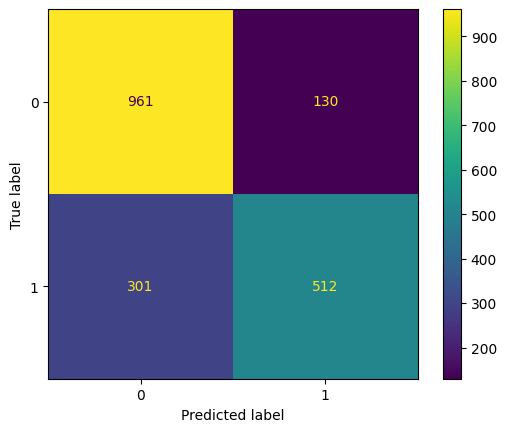

In [326]:
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])
from sklearn import metrics

# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

cm1=metrics.confusion_matrix(y_test, y_pred_class)
cm1_display = ConfusionMatrixDisplay(cm1).plot()

In [327]:
train_tweets = df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = df['target'].values

In [328]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13699

In [329]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [330]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3634,  467,  202, ...,    0,    0,    0],
       [ 136,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1806, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  161, 2636, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

In [331]:
#GloVe
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [332]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [345]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
178/179 [============================>.] - ETA: 0s - loss: 0.7958 - accuracy: 0.5542
Epoch 1: val_loss improved from inf to 0.68094, saving model to model.h5
179/179 [==============================] - 12s 40ms/step - loss: 0.7950 - accuracy: 0.5547 - val_loss: 0.6809 - val_accuracy: 0.5756 - lr: 0.0010
Epoch 2/7
179/179 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.6236
Epoch 2: val_loss improved from 0.68094 to 0.60972, saving model to model.h5
179/179 [==============================] - 8s 42ms/step - loss: 0.6649 - accuracy: 0.6236 - val_loss: 0.6097 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 3/7
179/179 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.6961
Epoch 3: val_loss improved from 0.60972 to 0.52346, saving model to model.h5
179/179 [==============================] - 7s 39ms/step - loss: 0.5908 - accuracy: 0.6961 - val_loss: 0.5235 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 4/7
179/179 [==============================] -

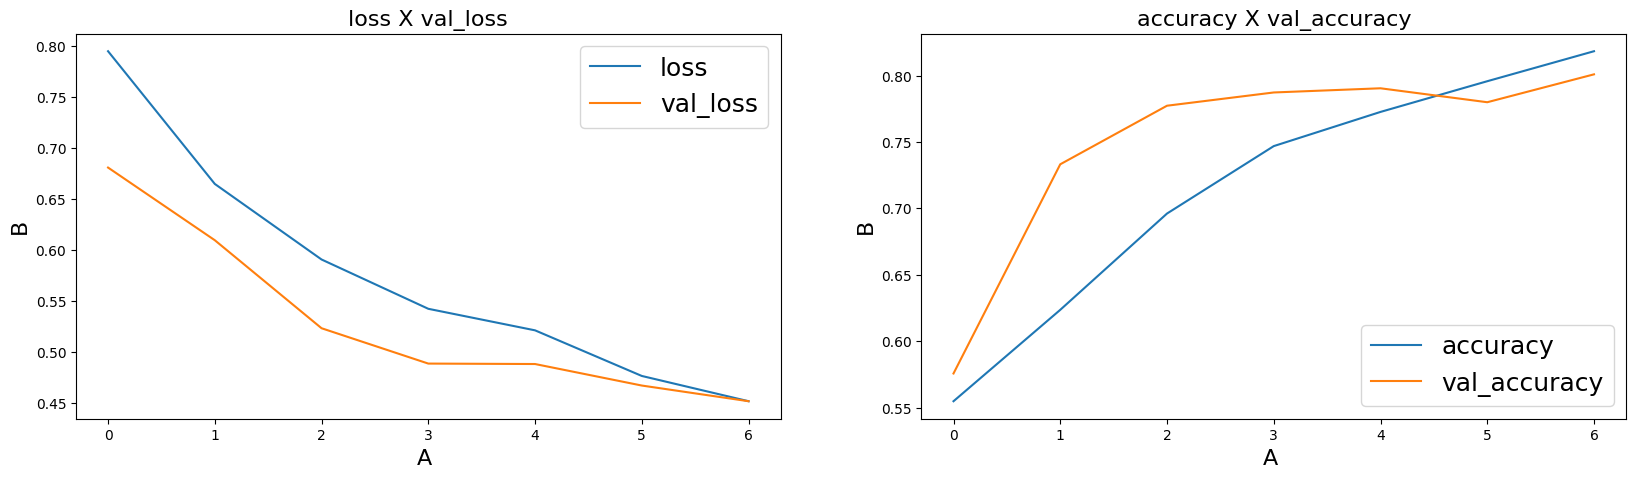

In [360]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [358]:
preds=np.argmax(model.predict(X_test),axis=1)
preds

60/60 [==============================] - 0s 7ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [359]:
show_metrics(preds, y_test)

F1-score:  0.0
Precision:  0.0
Recall:  0.0
Acuracy:  0.5656512605042017
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.57      0.72      1904
           1       0.00      0.00      0.00         0

    accuracy                           0.57      1904
   macro avg       0.50      0.28      0.36      1904
weighted avg       1.00      0.57      0.72      1904



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

